https://www.tensorflow.org/tutorials/images/classification#load_data_using_a_keras_utility

# Import libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
import os      # Used to navigate file structure
import cv2     # Used for image processing
import imghdr  # Used to collect information about the images
import numpy as np
import matplotlib.pyplot as plt   # Used for plotting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, MaxPool2D, BatchNormalization, Rescaling
from tensorflow.keras import layers
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Load data

In [3]:
# Create a training dataset from our training image directory
train_data = tf.keras.utils.image_dataset_from_directory('../input/emotion-even-dataset/project data/train', image_size=(256,256),
                                                        validation_split=0.2,subset="training",seed=123, batch_size=64)

Found 14400 files belonging to 3 classes.
Using 11520 files for training.


In [4]:
# Create a validation dataset from our training image directory
validation_data = tf.keras.utils.image_dataset_from_directory('../input/emotion-even-dataset/project data/train', image_size=(256,256),
                                                       validation_split=0.2,subset="validation",seed=123, batch_size=64)

Found 14400 files belonging to 3 classes.
Using 2880 files for validation.


In [5]:
# Print the class names that we have
class_names = train_data.class_names
print(class_names)

['happy', 'neutral', 'sad']


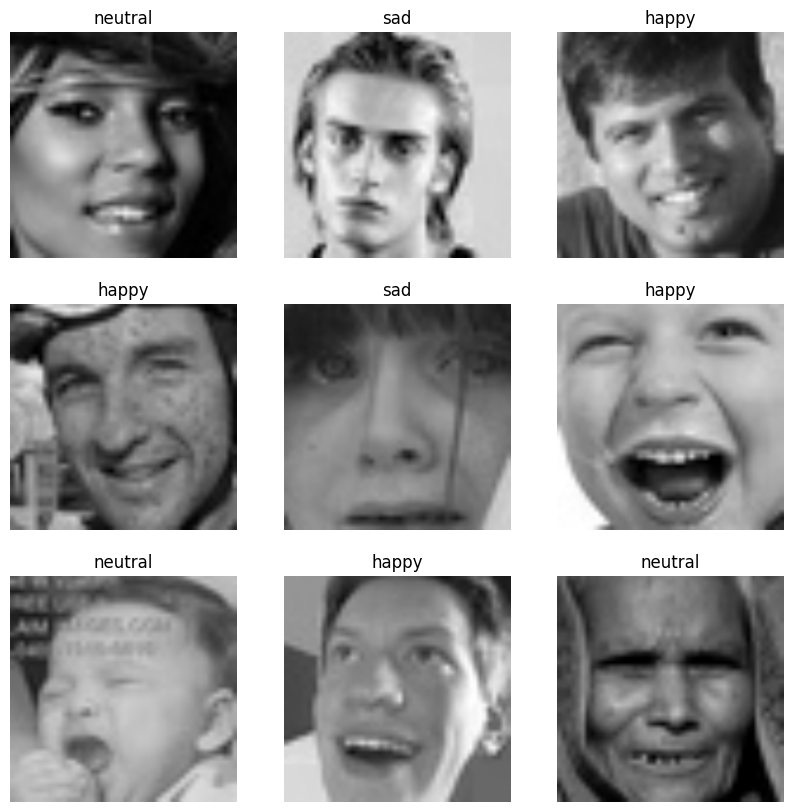

In [6]:
# Plot some of the images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)

(64, 3)


In [7]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

# Model building

## Data augmentation & Rescaling.

Rescaling the data, more specificaly the RGB values, to be between 0-1 will make it much easier for our CNN model to learn valueable patterns.
Instead of applying this approach before model building, we will include the rescaling inside of the model building. Data augmentation is when we modify the input data, with rotation for example, in order to increase our model training size and achieve better results, we will include the rescaling inside of the model building. This will make it much easier for model deployment.

In [8]:
# Creating a data augmentation step that will be used in the model
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### CNN model with data augmentation and colour rescaling

In [24]:
dac_model= tf.keras.models.Sequential()
dac_model.add(Rescaling(1./255, input_shape=(256, 256, 3)))
dac_model.add(data_augmentation)
dac_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256,3)))
dac_model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
dac_model.add(BatchNormalization())
dac_model.add(MaxPool2D(pool_size=(2, 2)))
dac_model.add(Dropout(0.25))

dac_model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
dac_model.add(BatchNormalization())
dac_model.add(MaxPool2D(pool_size=(2, 2)))
dac_model.add(Dropout(0.25))
    
dac_model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
dac_model.add(BatchNormalization())
dac_model.add(MaxPool2D(pool_size=(2, 2)))
dac_model.add(Dropout(0.25))

dac_model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
dac_model.add(BatchNormalization())
dac_model.add(MaxPool2D(pool_size=(2, 2)))
dac_model.add(Dropout(0.25))

dac_model.add(Flatten()) 
dac_model.add(Dense(256,activation = 'relu'))
dac_model.add(BatchNormalization())
dac_model.add(Dropout(0.25))
    
dac_model.add(Dense(512,activation = 'relu'))
dac_model.add(BatchNormalization())
dac_model.add(Dropout(0.25))

dac_model.add(Dense(3, activation='softmax'))

dac_model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
  )

In [25]:
epochs=10
history = dac_model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs,
)

Epoch 1/10


2023-10-05 12:02:22.091691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


213/213 [==============================] - 118s 545ms/step - loss: 8.1698 - accuracy: 0.3978 - val_loss: 9.0128 - val_accuracy: 0.4256

Epoch 2/10

213/213 [==============================] - 117s 544ms/step - loss: 6.8890 - accuracy: 0.4382 - val_loss: 7.5029 - val_accuracy: 0.3886

Epoch 3/10

213/213 [==============================] - 117s 546ms/step - loss: 5.6422 - accuracy: 0.4597 - val_loss: 6.6193 - val_accuracy: 0.3692

Epoch 4/10

213/213 [==============================] - 116s 542ms/step - loss: 4.5557 - accuracy: 0.4769 - val_loss: 4.3827 - val_accuracy: 0.4318

Epoch 5/10

213/213 [==============================] - 116s 543ms/step - loss: 3.6645 - accuracy: 0.5040 - val_loss: 3.5276 - val_accuracy: 0.4865

Epoch 6/10

213/213 [==============================] - 116s 542ms/step - loss: 2.9973 - accuracy: 0.5048 - val_loss: 2.9844 - val_accuracy: 0.3983

Epoch 7/10

213/213 [==============================] - 116s 542ms/step - loss: 2.5216 - accuracy: 0.5106 - val_loss: 2.3162 

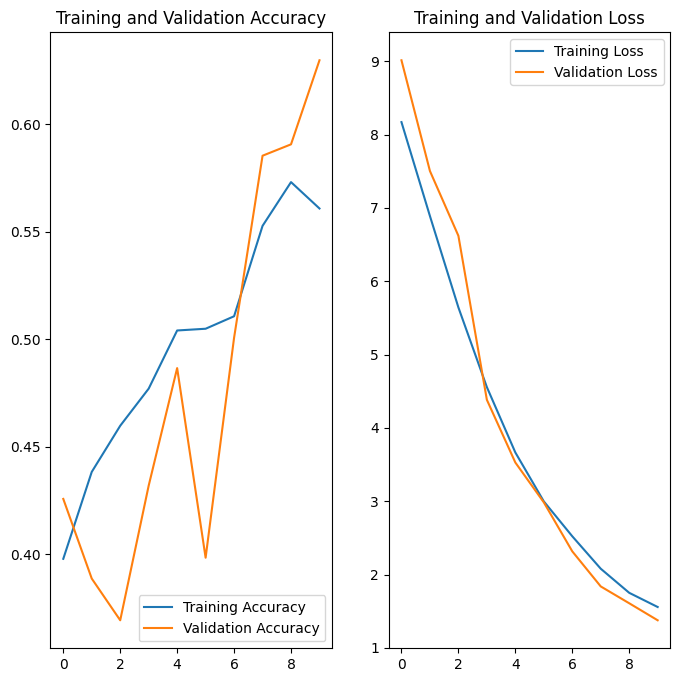

In [26]:
# Visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see, we achieved a validation accuracy of 62.96% with the training accuracy only being 57.3%. This is a difficult dataset and better data might increase our model's accuracy.

Our first model was with rescaling and data augmentation. Let's try it without these methods and train the model only on a basic CNN.

# Model without rescaling and without data augmentation

In [32]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
  )

In [33]:
epochs=10
history = model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/10


2023-10-05 12:56:16.227647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


213/213 [==============================] - 117s 539ms/step - loss: 8.0922 - accuracy: 0.4705 - val_loss: 12.7486 - val_accuracy: 0.4012

Epoch 2/10

213/213 [==============================] - 115s 539ms/step - loss: 6.9249 - accuracy: 0.5362 - val_loss: 10.5997 - val_accuracy: 0.4494

Epoch 3/10

213/213 [==============================] - 115s 538ms/step - loss: 5.7373 - accuracy: 0.5669 - val_loss: 6.9277 - val_accuracy: 0.4818

Epoch 4/10

213/213 [==============================] - 115s 538ms/step - loss: 4.6869 - accuracy: 0.6099 - val_loss: 4.8240 - val_accuracy: 0.5729

Epoch 5/10

213/213 [==============================] - 114s 534ms/step - loss: 3.7741 - accuracy: 0.6445 - val_loss: 3.7157 - val_accuracy: 0.6105

Epoch 6/10

213/213 [==============================] - 114s 533ms/step - loss: 3.0839 - accuracy: 0.6706 - val_loss: 3.2156 - val_accuracy: 0.6005

Epoch 7/10

213/213 [==============================] - 115s 539ms/step - loss: 2.5446 - accuracy: 0.6935 - val_loss: 2.569

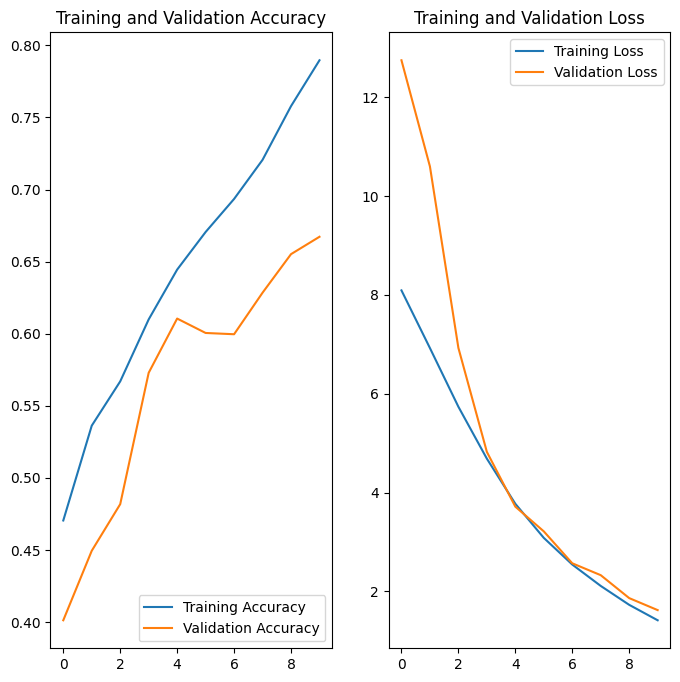

In [34]:
# Visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see, our new model without rescaling and without data augmentation performed slightly better on the validation dataset reaching 66.73%, and achieved 78.97% in the training data. It is clear that this basic model performed better and therefore we will be using it to make our classifications.

In [37]:
# Save this model since it is the best performer
model.save('/kaggle/working/emotion_classifier.keras')

Before we end the training, we can also use something called a 'Tranfer model'. The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. This is what we will be doing with a pretrained VGG16 model.

## VGG16 Transfer learning model

In [8]:
vgg16_model = Sequential()
vgg16_model.add(VGG16(include_top = False, weights = 'imagenet', input_shape = (256,256,3)))
vgg16_model.add(Flatten())
vgg16_model.add(Dense(512, activation = 'relu'))
vgg16_model.add(Dense(3, activation = 'softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
vgg16_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [10]:
epochs=10
history = vgg16_model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/10
180/180 [==============================] - 120s 548ms/step - loss: 3306575872.0000 - accuracy: 0.3300 - val_loss: 1.0986 - val_accuracy: 0.3271
Epoch 2/10
180/180 [==============================] - 99s 545ms/step - loss: 1.0987 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3271
Epoch 3/10
180/180 [==============================] - 99s 546ms/step - loss: 1.0987 - accuracy: 0.3319 - val_loss: 1.0987 - val_accuracy: 0.3271
Epoch 4/10
180/180 [==============================] - 99s 544ms/step - loss: 1.0987 - accuracy: 0.3340 - val_loss: 1.0987 - val_accuracy: 0.3271
Epoch 5/10
180/180 [==============================] - 99s 546ms/step - loss: 1.0987 - accuracy: 0.3349 - val_loss: 1.0987 - val_accuracy: 0.3271
Epoch 6/10
180/180 [==============================] - 99s 545ms/step - loss: 1.0987 - accuracy: 0.3334 - val_loss: 1.0987 - val_accuracy: 0.3271
Epoch 7/10
180/180 [==============================] - 99s 546ms/step - loss: 1.0987 - accuracy: 0.3349 - val_loss: 1.098

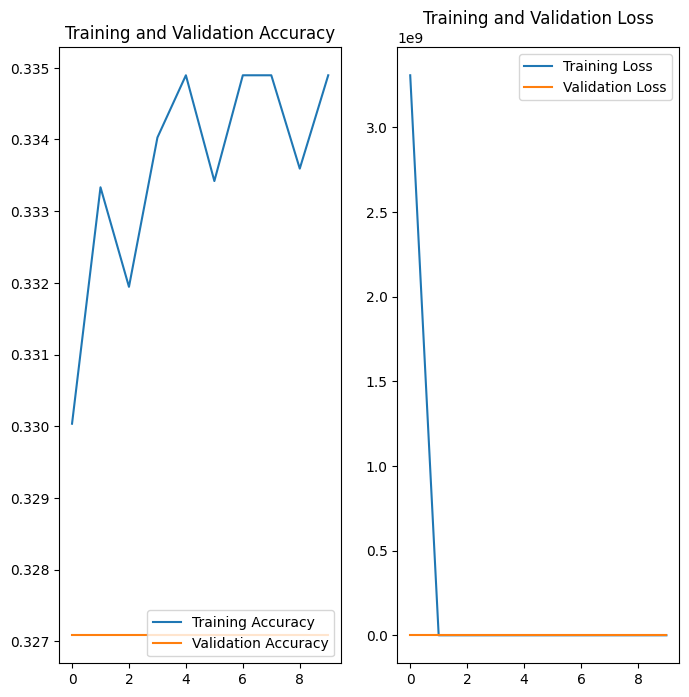

In [11]:
# Visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see, our VGG16 model only achieved an accuracy is onl 32.71% which is not very good. This might be because the model is too simple or was not trained on human faces. So we will be using the previous model that performed the best.